<a href="https://colab.research.google.com/github/DjordjeRadovanovic/PPPO_Projekat_IT39_2020/blob/main/PPPO_Projekat_IT39_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Principi prezentacije i prepoznavanja oblika 2023/2024**


**Đorđe Radovanović IT39/2020**

**Tema:** Klasifikacija lišća

## **Sadržaj**

1. Uvod
2. Tema
3. Učitavanje dataseta
4. Projekat
5. Zaključak
6. Literatura

## **1. Uvod**

## **2. Metodologija**

## **3. Učitavanje dataseta**

Prvi korak je učitavanje seta podataka koji će se koristiti prilikom treniranja modela. Da bi se to uradilo, neophodno je skinuti .zip fajl koji sadrži sve potrebne podatke, pomoću **wget** komande.

In [1]:
!wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1r4yy2ZIUGoyESydQzY39L-0s8ld7fuXr&confirm=xxx' -O Leaf_Classification.zip

--2024-06-15 18:51:26--  https://drive.usercontent.google.com/download?id=1r4yy2ZIUGoyESydQzY39L-0s8ld7fuXr&confirm=xxx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.202.132, 2607:f8b0:400e:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.202.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35953027 (34M) [application/octet-stream]
Saving to: ‘Leaf_Classification.zip’

Leaf_Classification 100%[===================>]  34.29M  59.5MB/s    in 0.6s    

2024-06-15 18:51:27 (59.5 MB/s) - ‘Leaf_Classification.zip’ saved [35953027/35953027]



Kada je Leaf_Classification.zip fajl skinut, potrebno je izvršiti dekompresiju podataka. To radimo pomoću **unzip** komande.

In [2]:
!unzip Leaf_Classification.zip

Archive:  Leaf_Classification.zip
  inflating: images.zip              
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: train.csv.zip           


Možemo uočiti da se u Leaf_Classification.zip fajlu nalaze još 4 posebna .zip fajla: *images.zip*, *sample_submission.csv.zip*, *train.csv.zip* i *test.csv.zip*. Analizom sadržaja ovih fajlova utvrđeno je da neće trebati *sample_submission.csv.zip*. Stoga, ponovićemo **unzip**, ali samo za ostala tri .zip fajla.

In [3]:
!unzip -qq images.zip
!unzip -qq train.csv.zip
!unzip -qq test.csv.zip

Sada imamo sve podatke raspakovane i spremne za korišćenje u daljem radu. Sledeći korak je pisanje samog koda za pripremu podataka, generisanje, treniranje i testiranje modela.

## **4. Projekat**

Prva stvar koju je potrebno uraditi je importovanje svih neophodnih biblioteka za projekat. Potrebno je koristiti **pandas** biblioteku za Python, koja ima DataFrame dvodimenzionalnu strukturu podataka koju možemo koristiti za predstavljanje tabelarnih CSV podataka. Takođe je potrebno koristiti **NumPy** biblioteku za matematičke operacije nad prosleđenim podacima.

VGG16 model možemo preuzeti iz **Keras** biblioteke, koja se koristi u svrhe mašinskog učenja. **Keras** biblioteka sadrži veliki broj modela, uključujuči i VGG16, koji će se koristiti. **Keras** koristi TensorFlow backend.

In [30]:
# Importovanje neophodnih biblioteka
import keras
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

Sledeći korak je učitavanje i sređivanje CSV podataka iz train.csv fajla. Učitavanje se vrši pomoću read_csv funkcije iz pandas paketa.

In [5]:
# Učitavanje podataka iz train.csv u train_data DataFrame
train_data = pd.read_csv('train.csv')

# Prikazivanje svih kolona
train_data.columns

Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

Vidimo da ima veliki broj kolona - marginX kolone, shapeX kolone, textureX kolone. Kako nisu potrebne za ovaj projekat, možemo ih izbaciti.

In [6]:
# Brisanje nepotrebnih kolona
i = 1
while i <= 64:
  del train_data['margin' + str(i)]
  del train_data['shape' + str(i)]
  del train_data['texture' + str(i)]
  i = i + 1

# Prikazivanje svih kolona
train_data.columns

Index(['id', 'species'], dtype='object')

Sada imamo samo dve kolone, **id** (koja predstavlja sliku u /images, poput 1.png), i **species** (klasa datog lista sa slike). Poslednja stvar koju treba odraditi je brisanje redova sa null vrednostima, ukoliko ih ima.

In [7]:
# Broj redova pre brisanja null vrednosti
print(train_data.shape[0])

# Brisanje redova sa null vrednostima
train_data.dropna()

# Broj redova nakon brisanja null vrednosti
print(train_data.shape[0])

990
990


Sada možemo dodati slike u train_data dataframe. To možemo obaviti kreiranjem nove kolone gde slika u koloni odgovara ID-ju ("1 -> images/1.jpg"). Potrebno je koristiti funkcije za manipulaciju slikama iz **Python Image Library** (**PIL**) biblioteke.

**VGG16** zahteva upotrebu 224x224 slika, pa se slike već u ovom koraku mogu prilagoditi datom formatu.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
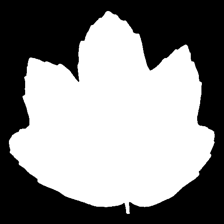

In [19]:
# Pretvaranje slike u NumPy array
def image_column(id):
  img = Image.open(f'images/{id}.jpg')
  img = img.resize((224, 224))          # 224x224 dimenzije
  return np.array(img)

# Dodavanje nove kolone sa slikom koja odgovara koloni 'id'
train_data['img'] = train_data['id'].apply(image_column)

# Primer slike
train_data['img'][0]

Podaci su sada u formatu koji je potreban za treniranje **VGG16** modela. Ostalo je da ih podelimo na dva dela, na podatke za treniranje i podatke za validaciju (kako bismo utvrdili da model ima odgovarajuću tačnost predikcije klasifikacije).

Podelu vršimo putem **train_test_split** funkcije iz biblioteke **sklearn**.

In [20]:
# Podela na podatke za treniranje i podatke za validaciju (odnos 80:20)
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

Sada imamo potpuno spremne dataframe-ove koje ćemo koristiti za treniranje i validaciju modela. Možemo uraditi sličan postupak za podatke koji će se koristiti za predikciju/testiranje modela.

In [22]:
# Učitavanje podataka iz test.csv u test_df DataFrame
test_df = pd.read_csv('test.csv')

# Brisanje nepotrebnih kolona
i = 1
while i <= 64:
  del test_df['margin' + str(i)]
  del test_df['shape' + str(i)]
  del test_df['texture' + str(i)]
  i = i + 1

# Dodavanje nove kolone sa slikom koja odgovara koloni 'id'
test_df['img'] = test_df['id'].apply(image_column)

test_df

,id,img
0,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,12,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,13,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
589,1576,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
590,1577,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
591,1579,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
592,1580,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Sada smo dobili tri vrste podataka:

* **train_df** - Podaci za treniranje modela
* **val_df** - Podaci za validaciju modela
* **test_df** - Podaci za testiranje modela

Nakon sređivanja i čišćenja podataka, sledeći korak je priprema **VGG16** modela.

In [53]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

for layer in vgg_conv.layers:
    print(layer, layer.trainable)

# Kreirajte model
model = keras.Sequential()

# Dodajte vgg konvolucionalni osnovni model
model.add(vgg_conv)

# Dodajte nove FC slojeve
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_df['species'].size, activation='softmax'))

# Prikažite rezime modela. Proverite broj parametara koji se mogu obučiti
model.summary()



from sklearn.preprocessing import LabelEncoder
# Example: Assuming train_df['species'] contains class names like 'Betula_Pendula'
encoder = LabelEncoder()
train_df['species'] = encoder.fit_transform(train_df['species'])
# Now train_df['species'] contains numerical labels instead of string class names
print(train_df['species'].unique())  # Verify unique numerical labels



# Convert DataFrame columns to numpy arrays if not already
X_train = np.stack(train_df['img'].values)
# Add channel dimension for RGB images
X_train = np.expand_dims(X_train, axis=-1)  # Adjust axis if images are grayscale or already have channels
# Repeat channel dimension for RGB images
X_train = np.repeat(X_train, 3, axis=-1)  # Repeat the last axis three times

y_train = np.array(train_df['species'])

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Assuming val_df is similarly prepared
X_val = np.stack(val_df['img'].values)
X_val = np.expand_dims(X_val, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)

y_val = np.array(val_df['species'])

print("X_train shape:", X_val.shape)
print("y_train shape:", y_val.shape)

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=12, epochs=10, validation_data=(X_val, y_val))

model.save('pppo_leaf_vgg16.h5')


<keras.src.engine.input_layer.InputLayer object at 0x7e6ecbe9fbb0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e6ecbe9fb20> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e6ecbec2aa0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7e6ecbe9caf0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e6ed86062f0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e6ed86c4b20> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7e6ecbef4d30> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e6ecbec1a50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e6ecbe45300> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e6ed90ddd50> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7e6ecbef7790> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7e6ecbef4550> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

X_train shape: (792, 224, 224, 3)
y_train shape: (792,)
X_train shape: (198, 224, 224, 3)
y_train shape: (198,)
Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (12, 1) and (12, 792) are incompatible


## **5. Zaključak**

## **6. Literatura**